
START: Rectified E2E FSO-OAM Simulation
[1] Initializing transmitter...
Spatial Modes: [(0, -1), (0, 1), (0, -3), (0, 3), (0, -4), (0, 4)]
Wavelength (nm): 1550.0, w0 (mm): 25.00
LDPC: n=2048, k=1537, rate=0.7505
Pilot ratio: 0.1, symbol_time (ps): 1000.0
Tx power total: 1.000 W, per-mode: 0.16667 W
    Grid: 256x256, D=0.497 m, delta=1.941 mm, chosen beam M^2=5.00
[2] Generating TX basis fields and scaling to P_tx_total...
    Verified transmit power (unit symbol on all modes): 1.000000 W (target 1.000000 W)
[3] Created 8 turbulence screens (frozen snapshot).
[4] Attenuation: atm 0.154 dB, geo 8.047 dB, expected P_rx=0.151327 W
[5] Generating TX frame/symbols...
Input info bits: 4914
Encoded bits: 8192 (effective rate ~0.5999)
Total symbols 4092 (682 per mode)
 Mode (0, -1): n_symbols=815, pilots=133
 Mode (0, 1): n_symbols=815, pilots=133
 Mode (0, -3): n_symbols=815, pilots=133
 Mode (0, 3): n_symbols=815, pilots=133
 Mode (0, -4): n_symbols=815, pilots=133
 Mode (0, 4): n_symbols=

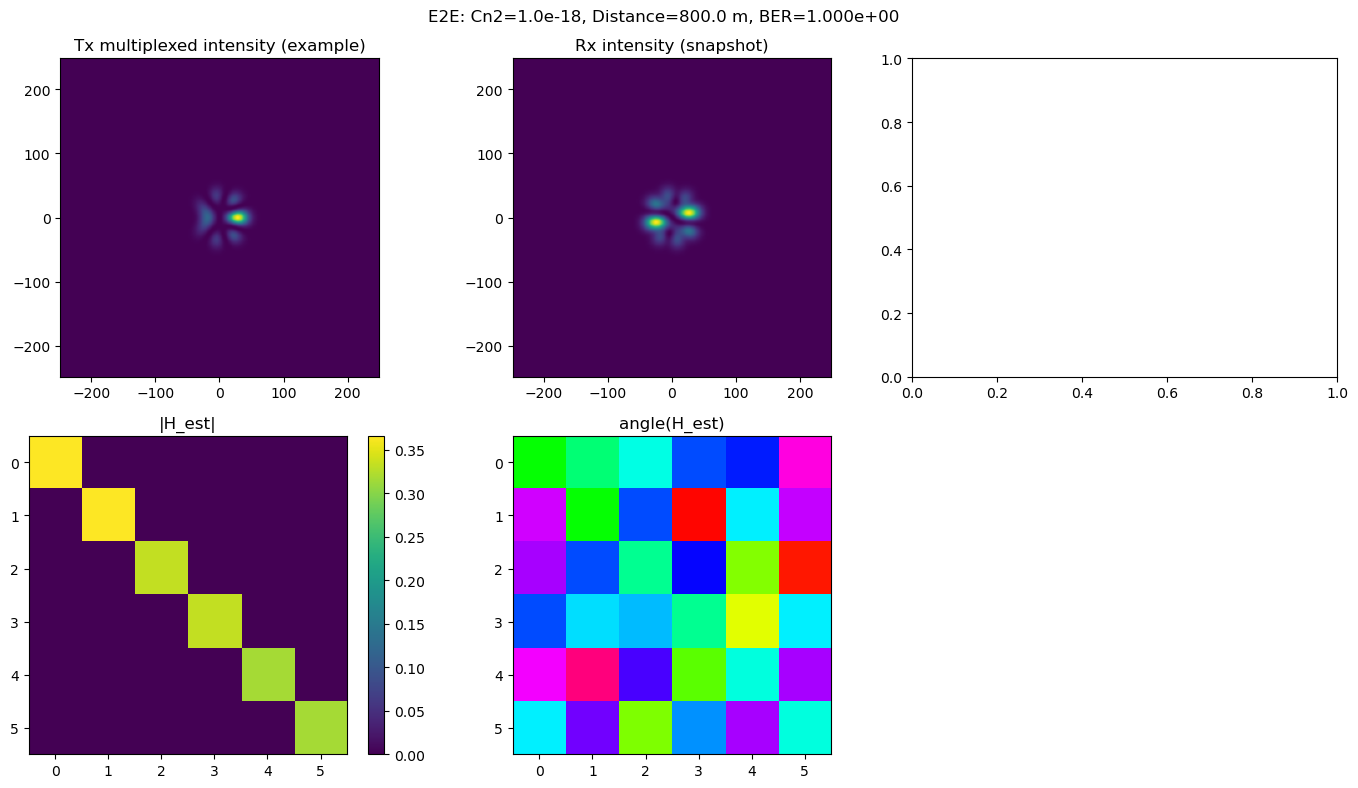

In [17]:
#!/usr/bin/env python3
# e2e_sim.py — Rectified End-to-End FSO-OAM demo driver
# Works with: encoding.py (rectified), receiver.py (rectified), turbulence.py (optional), lgBeam.py (optional)
# Produces robust fallbacks and improved diagnostics.

import os
import sys
import warnings
from datetime import datetime

try:
    SCRIPT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    SCRIPT_DIR = os.getcwd()
sys.path.insert(0, SCRIPT_DIR)

import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
np.random.seed(42)

# -------------------------
# Imports with safe fallbacks
# -------------------------
try:
    from encoding import encodingRunner, QPSKModulator, PyLDPCWrapper, PilotHandler, FSO_MDM_Frame
except Exception as e:
    raise ImportError(f"encoding.py import failed (needs encodingRunner, PyLDPCWrapper, PilotHandler, QPSKModulator): {e}")

# receiver: expects FSORx.receive_frame(rx_fields, tx_frame, original_data_bits, verbose=..)
try:
    from receiver import FSORx
except Exception as e:
    raise ImportError(f"receiver.py import failed (needs FSORx): {e}")

# turbulence helpers (optional)
try:
    from turbulence import AtmosphericTurbulence, create_multi_layer_screens, apply_multi_layer_turbulence
except Exception:
    AtmosphericTurbulence = None
    create_multi_layer_screens = None
    apply_multi_layer_turbulence = None
    warnings.warn("turbulence.* not importable; propagation will be pristine (no phase screens).")

# lgBeam optional
try:
    from lgBeam import LaguerreGaussianBeam
except Exception:
    LaguerreGaussianBeam = None
    warnings.warn("lgBeam not importable; beams may be unavailable (encoder will still work if it handled None beams).")

# attenuation helpers — attempt to import user file, else provide simple fallbacks
try:
    from fsplAtmAttenuation import calculate_kim_attenuation, calculate_geometric_loss
except Exception:
    calculate_kim_attenuation = None
    calculate_geometric_loss = None
    warnings.warn("fsplAtmAttenuation not available — using simple fallbacks for attenuation/geo-loss.")


# -------------------------
# SimulationConfig (same pattern you used)
# -------------------------
class SimulationConfig:
    WAVELENGTH = 1550e-9  # m
    W0 = 25e-3            # m

    DISTANCE = 800.0      # m
    RECEIVER_DIAMETER = 0.3  # m
    P_TX_TOTAL_W = 1.0

    SPATIAL_MODES = [(0, -1), (0, 1), (0, -3), (0, 3), (0, -4), (0, 4)]

    CN2 = 1e-18
    L0 = 10.0
    L0_INNER = 0.005
    NUM_SCREENS = 8

    WEATHER = "clear"

    FEC_RATE = 0.8
    PILOT_RATIO = 0.1

    # choose N_INFO_BITS so that encoder's ldpc.k divides or pad works
    N_INFO_BITS = 819 * len(SPATIAL_MODES)

    N_GRID = 256
    OVERSAMPLING = 1

    EQ_METHOD = "zf"
    ADD_NOISE = False
    SNR_DB = 50

    PLOT_DIR = os.path.join(SCRIPT_DIR, "e2e_results")
    DPI = 200


# -------------------------
# Helper wrappers
# -------------------------
def safe_calculate_geometric_loss(beam_obj, distance, rx_radius):
    """Try provided function; fallback to simple circular collection fraction using Gaussian waist."""
    if calculate_geometric_loss is not None:
        try:
            return calculate_geometric_loss(beam_obj, distance, rx_radius)
        except Exception:
            pass
    # fallback: assume Gaussian beam, fraction = 1 - exp(-2*(rx_radius/wz)^2)
    try:
        wz = beam_obj.beam_waist(distance) if (beam_obj is not None and hasattr(beam_obj, "beam_waist")) else 0.05
        eta = 1.0 - np.exp(-2.0 * (rx_radius ** 2) / (wz ** 2 + 1e-12))
        Lgeo_db = -20.0 * np.log10(max(1e-12, np.sqrt(eta)))  # amplitude dB
        return Lgeo_db, eta
    except Exception:
        return 0.0, 1.0


def safe_kim_attenuation(wavelength_nm, visibility_km=23.0):
    """Return dB/km according to Kim model if available; otherwise simple empirical fallback."""
    if calculate_kim_attenuation is not None:
        try:
            return calculate_kim_attenuation(wavelength_nm, visibility_km)
        except Exception:
            pass
    # simple fallback: very clear -> 0.05 dB/km, hazy -> >1 dB/km; use visibility argument
    if visibility_km >= 20:
        return 0.05
    elif visibility_km >= 5:
        return 0.5
    else:
        return 2.0


def apply_turbulence_safe(initial_field, base_beam, layers, total_distance, N, oversampling, L0, l0):
    """Try multiple call forms for apply_multi_layer_turbulence, else return pristine result dict."""
    if apply_multi_layer_turbulence is None:
        return {"final_field": initial_field, "pristine_field": initial_field}
    # try common signatures
    try:
        return apply_multi_layer_turbulence(
            initial_field, base_beam, layers, total_distance,
            N=N, oversampling=oversampling, L0=L0, l0=l0, verbose=False
        )
    except TypeError:
        try:
            # some variations: apply_multi_layer_turbulence(field, layers, z, N=..)
            return apply_multi_layer_turbulence(initial_field, layers, total_distance, N=N)
        except Exception:
            pass
    except Exception:
        pass
    # fallback: attempt simple call
    try:
        return apply_multi_layer_turbulence(initial_field, layers, total_distance)
    except Exception:
        return {"final_field": initial_field, "pristine_field": initial_field}


# -------------------------
# Main E2E runner (rectified)
# -------------------------
def run_e2e_simulation(cfg: SimulationConfig):
    t0 = datetime.now()
    print("\n" + "=" * 72)
    print("START: Rectified E2E FSO-OAM Simulation")
    print("=" * 72)

    # instantiate transmitter
    print("[1] Initializing transmitter...")
    tx = encodingRunner(
        spatial_modes=cfg.SPATIAL_MODES,
        wavelength=cfg.WAVELENGTH,
        w0=cfg.W0,
        fec_rate=cfg.FEC_RATE,
        pilot_ratio=cfg.PILOT_RATIO
    )

    # pick a valid LG beam (non-None) for analytic properties; if none, fall back to synthetic beam-like object
    valid_beams = [b for b in getattr(tx, "lg_beams", {}).values() if b is not None]
    if valid_beams:
        max_m2_beam = max(valid_beams, key=lambda b: getattr(b, "M_squared", 1.0))
    else:
        # create a synthetic minimal object with beam_waist method
        class _SyntheticBeam:
            def __init__(self, w0, wavelength):
                self.w0 = w0
                self.p = 0; self.l = 0; self.M_squared = 1.0
            def beam_waist(self, z):
                zR = np.pi * (cfg.W0 ** 2) / cfg.WAVELENGTH
                return cfg.W0 * np.sqrt(1.0 + (z / (zR + 1e-12)) ** 2)
        max_m2_beam = _SyntheticBeam(cfg.W0, cfg.WAVELENGTH)
        warnings.warn("No valid LG beams found in transmitter; using synthetic beam for geometry estimates.")

    # build grid centered on expected beam size at rx
    w_L = max_m2_beam.beam_waist(cfg.DISTANCE)
    D = float(cfg.OVERSAMPLING) * 6.0 * float(w_L)
    N = int(cfg.N_GRID)
    delta = D / float(N)
    x = np.linspace(-D/2, D/2, N)
    X, Y = np.meshgrid(x, x, indexing="ij")
    R = np.sqrt(X**2 + Y**2)
    PHI = np.arctan2(Y, X)
    grid_info = {"x": x, "y": x, "X": X, "Y": Y, "R": R, "PHI": PHI, "delta": delta, "D": D, "N": N}

    print(f"    Grid: {N}x{N}, D={D:.3f} m, delta={delta*1e3:.3f} mm, chosen beam M^2={max_m2_beam.M_squared:.2f}")

    # Precompute basis fields (scaled to total TX power)
    print("[2] Generating TX basis fields and scaling to P_tx_total...")
    dA = delta**2
    tx_basis_fields = {}
    basis_energy = {}
    n_modes = len(cfg.SPATIAL_MODES)

    for mk in cfg.SPATIAL_MODES:
        beam_obj = tx.lg_beams.get(mk, None) if hasattr(tx, "lg_beams") else None
        # if beam_obj exists, use its generator; otherwise create gaussian fallback
        if beam_obj is not None:
            E0 = beam_obj.generate_beam_field(R, PHI, 0.0)
        else:
            # simple Gaussian fallback with w0
            w0 = cfg.W0
            E0 = np.exp(-(R ** 2) / (w0 ** 2)).astype(np.complex128)
        e = np.sum(np.abs(E0) ** 2) * dA
        basis_energy[mk] = max(e, 1e-20)
        scale = np.sqrt(cfg.P_TX_TOTAL_W / (n_modes * basis_energy[mk]))
        tx_basis_fields[mk] = E0 * scale

    # quick verify total transmit power for unit symbols
    E_tx_test = np.zeros_like(X, dtype=complex)
    for mk in cfg.SPATIAL_MODES:
        E_tx_test += tx_basis_fields[mk]
    total_tx_power = np.sum(np.abs(E_tx_test) ** 2) * dA
    print(f"    Verified transmit power (unit symbol on all modes): {total_tx_power:.6f} W (target {cfg.P_TX_TOTAL_W:.6f} W)")

    # instantiate turbulence model (optional) and create frozen screens
    layers = None
    if AtmosphericTurbulence is not None and create_multi_layer_screens is not None:
        try:
            layers = create_multi_layer_screens(cfg.DISTANCE, cfg.NUM_SCREENS, cfg.WAVELENGTH,
                                                ground_Cn2=cfg.CN2, L0=cfg.L0, l0=cfg.L0_INNER, cn2_model="uniform", verbose=False)
            print(f"[3] Created {len(layers)} turbulence screens (frozen snapshot).")
        except Exception as e:
            warnings.warn(f"create_multi_layer_screens failed: {e}; will run pristine channel.")
            layers = None
    else:
        print("[3] Turbulence modules not available — using pristine channel.")

    # attenuation: geometric + atm (use safe wrappers)
    rx_radius = cfg.RECEIVER_DIAMETER / 2.0
    L_geo_db, eta_geo = safe_calculate_geometric_loss(max_m2_beam, cfg.DISTANCE, rx_radius)
    atm_alpha_db_per_km = safe_kim_attenuation(cfg.WAVELENGTH * 1e9, visibility_km=23.0)
    L_atm_db = atm_alpha_db_per_km * (cfg.DISTANCE / 1000.0)
    amp_loss = 10.0 ** (-L_atm_db / 20.0)
    coll_eff = eta_geo * (amp_loss ** 2)
    P_rx_expected = cfg.P_TX_TOTAL_W * coll_eff
    print(f"[4] Attenuation: atm {L_atm_db:.3f} dB, geo {L_geo_db:.3f} dB, expected P_rx={P_rx_expected:.6f} W")

    # Transmit frame: generate symbols using encodingRunner
    print("[5] Generating TX frame/symbols...")
    data_bits = np.random.randint(0, 2, cfg.N_INFO_BITS)
    frame = tx.transmit(data_bits, generate_3d_field=False, verbose=True)
    tx_signals = frame.tx_signals
    # ensure consistent ordering across cfg.SPATIAL_MODES
    symbol_lengths = [len(tx_signals[mk]["symbols"]) for mk in cfg.SPATIAL_MODES]
    if min(symbol_lengths) == 0:
        raise RuntimeError("Transmitter produced zero-length symbol array for at least one mode.")
    n_symbols = int(min(symbol_lengths))
    print(f"    Symbols per mode (minimum) = {n_symbols}")

    # Optionally check pilot_positions from the first mode
    first_mode = cfg.SPATIAL_MODES[0]
    pilot_positions = np.asarray(tx_signals[first_mode].get("pilot_positions", []), dtype=int)
    print(f"    Pilot count (example mode) = {len(pilot_positions)}")

    # setup receiver (share same LDPC/pilot handler)
    print("[6] Initializing receiver (shares LDPC/pilot handler with TX)...")
    rx = FSORx(
        spatial_modes=cfg.SPATIAL_MODES,
        wavelength=cfg.WAVELENGTH,
        w0=cfg.W0,
        z_distance=cfg.DISTANCE,
        pilot_handler=tx.pilot_handler,
        ldpc_instance=tx.ldpc,
        eq_method=cfg.EQ_METHOD,
        receiver_radius=rx_radius
    )

    # Propagate each symbol through channel (frozen snapshot)
    print("[7] Propagating symbols (may be slow) ...")
    E_rx_sequence = []
    for t in range(n_symbols):
        # build multiplexed field for symbol t
        E_tx = np.zeros((N, N), dtype=complex)
        for mk in cfg.SPATIAL_MODES:
            sym = tx_signals[mk]["symbols"][t]
            E_tx += tx_basis_fields[mk] * sym

        # apply turbulence (safe wrapper)
        turb_res = apply_turbulence_safe(E_tx, max_m2_beam, layers, cfg.DISTANCE, N=N,
                                         oversampling=cfg.OVERSAMPLING, L0=cfg.L0, l0=cfg.L0_INNER)
        E_rx = turb_res.get("final_field", E_tx)
        # apply attenuation amplitude factor
        E_rx = E_rx * amp_loss

        # apply aperture mask
        aperture_mask = (R <= rx_radius).astype(float)
        E_rx = E_rx * aperture_mask

        # optionally add noise (per-pixel)
        if cfg.ADD_NOISE:
            # estimate per-pixel noise variance from desired SNR and average aperture intensity
            power_total = np.sum(np.abs(E_rx) ** 2) * dA
            avg_pixel = power_total / max(1.0, np.sum(aperture_mask))
            snr_lin = 10.0 ** (cfg.SNR_DB / 10.0)
            noise_var = avg_pixel / snr_lin
            noise = (np.sqrt(noise_var / 2.0) *
                     (np.random.randn(N, N) + 1j * np.random.randn(N, N)))
            E_rx = E_rx + noise

        E_rx_sequence.append(E_rx)

        if (t + 1) % max(1, n_symbols // 5) == 0 or (t + 1) <= 5:
            print(f"    propagated symbol {t+1}/{n_symbols}")

    print("    propagation complete.")

    # Now hand over to receiver.receive_frame
    print("[8] Running digital receiver (projection, LS channel est, equalize, decode)...")
    # receiver.receive_frame expects rx_field_sequence, tx_frame (FSO_MDM_Frame), original_data_bits
    if getattr(frame, "grid_info", None) is None:
        warnings.warn("frame.grid_info is empty — attaching local grid_info to ensure receiver can project fields.")
        frame.grid_info = grid_info

    missing_keys = [k for k in ("R", "PHI", "delta") if k not in getattr(frame, "grid_info", {})]
    if missing_keys:
        raise ValueError(f"frame.grid_info missing required keys: {missing_keys}")

    #  - check rx field array sizing matches grid
    if len(E_rx_sequence) > 0:
        sample_field = E_rx_sequence[0]
        if not (hasattr(frame, "grid_info") and "N" in frame.grid_info):
            # infer N from grid arrays
            Ngrid = frame.grid_info.get("N", frame.grid_info["X"].shape[0])
            frame.grid_info["N"] = int(Ngrid)
        expected_shape = (int(frame.grid_info["N"]), int(frame.grid_info["N"]))
        if sample_field.shape != expected_shape:
            warnings.warn(f"Shape mismatch: sample E_rx field {sample_field.shape} != grid N,N {expected_shape}. "
                          "Projection may fail or produce NaNs.")
    # ===== PATCH END =====

    decoded_bits, metrics = rx.receive_frame(E_rx_sequence, frame, original_data_bits=data_bits, verbose=True)

    # final summary
    t1 = datetime.now()
    print("\n" + "=" * 72)
    print("E2E Simulation Complete")
    print(f"Elapsed time: {(t1 - t0).total_seconds():.1f} s")
    print(f"Total info bits: {metrics.get('total_bits', len(data_bits))}")
    print(f"Bit errors: {metrics.get('bit_errors', 'N/A')}")
    print(f"BER: {metrics.get('ber', np.nan):.4e}")
    print("=" * 72)

    results = {
        "config": cfg,
        "metrics": metrics,
        "grid_info": grid_info,
        "tx_frame": frame,
        "E_tx_example": E_tx_test,
        "E_rx_example": E_rx_sequence[0] if E_rx_sequence else None,
        "H_est": metrics.get("H_est", None)
    }
    return results


# -------------------------
# plotting helper (light)
# -------------------------
def plot_e2e_results(results, save_path=None):
    cfg = results["config"]
    grid = results["grid_info"]
    H = results["H_est"]
    E_tx = np.abs(results["E_tx_example"]) ** 2
    E_rx = np.abs(results["E_rx_example"]) ** 2

    extent_mm = grid["D"] * 1e3 / 2.0
    fig, axs = plt.subplots(2, 3, figsize=(14, 8))
    axs[0, 0].imshow(E_tx.T, origin="lower", extent=[-extent_mm, extent_mm, -extent_mm, extent_mm])
    axs[0, 0].set_title("Tx multiplexed intensity (example)")
    axs[0, 1].imshow(E_rx.T, origin="lower", extent=[-extent_mm, extent_mm, -extent_mm, extent_mm])
    axs[0, 1].set_title("Rx intensity (snapshot)")

    if H is not None:
        im = axs[1, 0].imshow(np.abs(H), interpolation="nearest")
        axs[1, 0].set_title("|H_est|")
        plt.colorbar(im, ax=axs[1, 0])
        axs[1, 1].imshow(np.angle(H), cmap="hsv", vmin=-np.pi, vmax=np.pi)
        axs[1, 1].set_title("angle(H_est)")

    axs[1, 2].axis("off")
    plt.suptitle(f"E2E: Cn2={cfg.CN2:.1e}, Distance={cfg.DISTANCE} m, BER={results['metrics'].get('ber', np.nan):.3e}")
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=cfg.DPI, bbox_inches="tight")
        print(f"Saved figure to {save_path}")
    return fig


# -------------------------
# run main if invoked
# -------------------------
if __name__ == "__main__":
    cfg = SimulationConfig()
    # quick debug overrides (uncomment as needed)
    # cfg.CN2 = 1e-20
    # cfg.ADD_NOISE = False
    # cfg.N_GRID = 128
    res = run_e2e_simulation(cfg)
    if res:
        plot_path = os.path.join(cfg.PLOT_DIR, "e2e_summary.png")
        fig = plot_e2e_results(res, save_path=plot_path)
        plt.show()
    else:
        print("Simulation failed or returned no results.")